## 初期設定

In [1]:
exp_name = '8288_MaxVitTinyTimm' # ファイル名とそろえる

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
import os, gc, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.signal import resample
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import scipy.signal as signal
from tqdm.notebook import tqdm
from scipy.signal import welch
import pandas as pd
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
import torch
import timm
from torch import nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split, KFold
from torch import nn, optim

In [3]:
train = sio.loadmat('dataset/train.mat')
test = sio.loadmat('dataset/test.mat')
reference = sio.loadmat('dataset/reference.mat')

In [4]:
# 筋電位データの特徴量の名前です
feature_name = ['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
                'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']

"""
16個の変数はインデックスの小さい順番から順番に以下のようなデータが配列されている.
- TibialisAnterior Right(脛骨前筋 右)
- TibialisAnterior Left(脛骨前筋 左)
- GastrocnemiusLateralis Right(外側広筋 右)
- GastrocnemiusLateralis Left(外側広筋 左)
- QuadricepsRectusFemoris Right(大腿四頭筋 直腿筋 右)
- QuadricepsRectusFemoris Left(大腿四頭筋 直腿筋 左)
- QuadricepsVastusLateralis Right(大腿四頭筋 外側広筋 右)
- QuadricepsVastusLateralis Left(大腿四頭筋 外側広筋 左)
- Semitendinosus Right(半腱様筋 右)
- Semitendinosus Left(半腱様筋 左)
- GluteusMaximus Right(大殿筋 右)
- GluteusMaximus Left(大殿筋 左)
- ErectorSpinaeIliocostalis Right(脊柱起立筋 右)
- ErectorSpinaeIliocostalis Left(脊柱起立筋 左)
- DeltoideusMedius Right(三角筋 右)
- DeltoideusMedius Left(三角筋 左)
"""

'\n16個の変数はインデックスの小さい順番から順番に以下のようなデータが配列されている.\n- TibialisAnterior Right(脛骨前筋 右)\n- TibialisAnterior Left(脛骨前筋 左)\n- GastrocnemiusLateralis Right(外側広筋 右)\n- GastrocnemiusLateralis Left(外側広筋 左)\n- QuadricepsRectusFemoris Right(大腿四頭筋 直腿筋 右)\n- QuadricepsRectusFemoris Left(大腿四頭筋 直腿筋 左)\n- QuadricepsVastusLateralis Right(大腿四頭筋 外側広筋 右)\n- QuadricepsVastusLateralis Left(大腿四頭筋 外側広筋 左)\n- Semitendinosus Right(半腱様筋 右)\n- Semitendinosus Left(半腱様筋 左)\n- GluteusMaximus Right(大殿筋 右)\n- GluteusMaximus Left(大殿筋 左)\n- ErectorSpinaeIliocostalis Right(脊柱起立筋 右)\n- ErectorSpinaeIliocostalis Left(脊柱起立筋 左)\n- DeltoideusMedius Right(三角筋 右)\n- DeltoideusMedius Left(三角筋 左)\n'

In [5]:
output_folder = "output/"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, exp_name), exist_ok=True)

In [6]:
import random

# 乱数シードの設定
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
seed_everything(seed)

In [7]:
import pickle

# データ保存の例
def save_data_with_pickle(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

# データ読み込みの例
def load_data_with_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

In [8]:
fold_num = 10

## 画像データ作成

In [9]:

for user_id in ["0001", "0002", "0003", "0004"]:
    x_array = train[user_id][0][0][0]
    y_array = train[user_id][0][0][1]
    
    # 形状を変更 (例: (319, 30, 3) -> (319, 3, 30))
    x_array = x_array.transpose(0, 2, 1)
    y_array = y_array.transpose(0, 2, 1)
    print(x_array.shape)  # デバッグ出力用
    print(y_array.shape)  # デバッグ出力用

    # 連結用リスト
    x_list = []
    y_list = []

    for i, x_arr in enumerate(x_array):
        x_df = pd.DataFrame()

        # DataFrameを作成
        for j, col in enumerate(feature_name):
            x_df[f"{col}"] = x_arr[:, j]
        
        # DataFrameをリストに追加
        x_list.append(x_df)

    for i, y_arr in enumerate(y_array):
        y_df = pd.DataFrame()

        # DataFrameを作成
        for j, col in enumerate(["vel_x", "vel_y", "vel_z"]):
            y_df[f"{col}"] = y_arr[:, j]
        
        # DataFrameをリストに追加
        y_list.append(y_df)
        
    # 各ユーザーのDataFrameを縦方向に連結
    combined_x_df = pd.concat(x_list, ignore_index=True)    
    combined_y_df = pd.concat(y_list, ignore_index=True)

(319, 1000, 16)
(319, 30, 3)
(300, 1000, 16)
(300, 30, 3)
(320, 1000, 16)
(320, 30, 3)
(320, 1000, 16)
(320, 30, 3)


In [10]:
combined_x_df

,TA R,TA L,LG R,LG L,RF R,RF L,VL R,VL L,ST R,ST L,GMAX R,GMAX L,EMI R,EMI L,DEL R,DEL L
0,-0.003685,-0.004045,0.003071,0.002793,-0.022490,0.066857,0.032043,0.032933,-0.002520,0.002295,0.036690,-0.008716,-0.030876,-0.001919,0.014210,-0.184499
1,-0.003618,-0.004797,0.002447,0.003183,-0.020808,0.064705,0.027666,0.028277,-0.000211,0.002422,0.035041,-0.004073,-0.024012,-0.003305,0.030699,-0.150667
2,-0.002857,-0.005815,0.003549,0.003366,-0.018080,0.055707,0.020507,0.001794,-0.000281,0.000364,0.032436,0.000188,-0.017436,-0.003732,0.041472,-0.102931
3,-0.001685,-0.006747,0.005349,0.002531,-0.015622,0.035341,0.012515,-0.008900,0.002615,-0.001309,0.028273,0.004461,-0.009070,-0.003917,0.041615,-0.059993
4,-0.000934,-0.007493,0.006023,0.001536,-0.014049,0.006167,0.008011,0.000092,0.014871,-0.000802,0.022859,0.008061,0.000062,-0.004496,0.031265,-0.031741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,-0.008251,-0.016979,0.017107,-0.014865,-0.011836,0.003691,0.001026,-0.030912,0.102386,0.247547,0.006949,-0.068903,0.026427,0.010834,0.001371,-0.049325
319996,-0.024334,-0.021732,0.013207,-0.004941,0.000678,0.006260,-0.003086,-0.006100,0.091205,0.187852,0.004879,-0.087235,0.033738,0.005094,0.000630,-0.050519
319997,-0.041140,-0.022125,0.012166,-0.000560,0.005171,0.008528,-0.004864,0.005459,0.065541,0.103289,0.003150,-0.097464,0.036731,0.000374,0.000636,-0.050555
319998,-0.055247,-0.019753,0.012537,-0.002767,0.004980,0.011835,-0.003430,0.009219,0.046428,0.030906,0.002606,-0.095646,0.033336,-0.002997,0.000822,-0.044202


In [11]:
x_df

,TA R,TA L,LG R,LG L,RF R,RF L,VL R,VL L,ST R,ST L,GMAX R,GMAX L,EMI R,EMI L,DEL R,DEL L
0,0.000173,0.000012,0.025217,0.000575,0.015460,-0.047896,-0.086595,0.272927,0.011166,-0.140817,0.010346,-0.009586,-0.028657,-0.000685,-0.011222,0.000996
1,-0.001027,0.002973,0.026504,-0.001013,0.024790,-0.045406,-0.103758,0.176403,0.010590,-0.115081,0.007762,-0.013079,-0.030955,-0.001811,-0.008906,-0.001504
2,-0.000144,0.005003,0.025412,-0.002477,0.030821,-0.039902,-0.111309,0.071171,0.007879,-0.073284,0.005357,-0.019525,-0.033233,-0.004330,-0.003677,-0.002562
3,0.002124,0.005219,0.021171,-0.002720,0.034942,-0.032382,-0.091470,0.039158,0.003868,-0.034424,0.004574,-0.028384,-0.032140,-0.006601,0.003621,-0.001196
4,0.003508,0.004621,0.014831,-0.001969,0.037912,-0.025327,-0.054549,0.052883,0.000455,-0.005399,0.005251,-0.034797,-0.024247,-0.006685,0.011610,0.001390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.008251,-0.016979,0.017107,-0.014865,-0.011836,0.003691,0.001026,-0.030912,0.102386,0.247547,0.006949,-0.068903,0.026427,0.010834,0.001371,-0.049325
996,-0.024334,-0.021732,0.013207,-0.004941,0.000678,0.006260,-0.003086,-0.006100,0.091205,0.187852,0.004879,-0.087235,0.033738,0.005094,0.000630,-0.050519
997,-0.041140,-0.022125,0.012166,-0.000560,0.005171,0.008528,-0.004864,0.005459,0.065541,0.103289,0.003150,-0.097464,0.036731,0.000374,0.000636,-0.050555
998,-0.055247,-0.019753,0.012537,-0.002767,0.004980,0.011835,-0.003430,0.009219,0.046428,0.030906,0.002606,-0.095646,0.033336,-0.002997,0.000822,-0.044202


#### 第一段階のラベル抽出

In [12]:
first_exp_name = "8248_ImageFeature-Effnetb0TorchV_EvalGMM"

In [13]:
# 学習用データ, oof予測から作成したlabel, prob
# labels_train = np.loadtxt(fname=os.path.join(output_folder, first_exp_name, f'all_train_classes.csv'),dtype="int32")
# probs_train = np.loadtxt(fname=os.path.join(output_folder, first_exp_name, f'all_train_probs.csv'), delimiter=',',dtype="float")

# 学習用データ, 正解速度データから作成したlabel, prob
labels_train = np.loadtxt(fname=os.path.join(output_folder, first_exp_name, f'all_train_classes_true.csv'),dtype="int32")
probs_train = np.loadtxt(fname=os.path.join(output_folder, first_exp_name, f'all_train_probs_true.csv'), delimiter=',',dtype="float")

# テスト用データ
labels_test = np.loadtxt(fname=os.path.join(output_folder, first_exp_name, f'all_test_classes.csv'),dtype="int32")
probs_test = np.loadtxt(fname=os.path.join(output_folder, first_exp_name, f'all_test_probs.csv'), delimiter=',',dtype="float")

print(probs_train.shape)

(1579, 3)


In [14]:
probs_train[0][2]

4.080470995265308e-27

In [15]:
labels_train

array([1, 0, 0, ..., 2, 0, 1], dtype=int32)

In [16]:
labels_test

array([1, 1, 2, ..., 2, 0, 2], dtype=int32)

In [17]:
print(len(labels_train))
print(len(labels_test))

1579
1579


# npyファイル生成（未生成の場合）

In [19]:
user_id_multiplier = 0.025
catg_multiplier = 0.025
# catg_multiplier = 0.5

4 x 256では4列並べる

In [20]:
images_folder = os.path.join(output_folder, exp_name, "train")
os.makedirs(images_folder, exist_ok=True)

image_shape2 = 4 # 横幅 (4 x256だが 4set並べるため)
image_shape2_set = 4 # 横幅セット数
image_shape1 = 256 # 縦幅
colnum = 16 # 列数
shift_amount = 150 # ずらし量

# 学習用データ(0001-0004)
catg_counter = 0
for user_id in ["0001", "0002", "0003", "0004"]:
    user_path = os.path.join(images_folder, user_id)
    os.makedirs(user_path, exist_ok=True)  # ユーザーIDごとのフォルダを作成

    x_array = train[user_id][0][0][0]
    x_array = x_array.transpose(0, 2, 1)
    print(x_array.shape)

    for i, x_arr in enumerate(x_array):
        image_data = np.zeros((256, 256))
        
        for j, feature in enumerate(feature_name):
            feature_data = x_arr[:, j]
            if j == 5 or j == 6:
                user_value = float(labels_train[catg_counter])*catg_multiplier # カテゴリ番号には0,1,2が入る
            else:
                user_value = float(user_id[-1]) * user_id_multiplier  # ユーザーIDの最後の文字を数値に変換
            
            padded_feature_data = np.pad(feature_data, (0, 24), mode='constant', constant_values=user_value)  # パディング部分にユーザーIDを追加
            reshaped_data = padded_feature_data.reshape((image_shape1, image_shape2))
            row, col = divmod(j, colnum)
            
            # 4つのセットを横に並べて画像データを構成
            for set_index in range(4):
                start_col = col * image_shape2 * image_shape2_set + set_index * image_shape2
                end_col = start_col + image_shape2
                image_data[row * image_shape1:(row + 1) * image_shape1, start_col:end_col] = reshaped_data

        image_data = np.roll(image_data, shift_amount, axis=0)  # 縦方向にシフト
        save_data_with_pickle(image_data, os.path.join(user_path, f"{i}.pkl"))
        catg_counter += 1

# 学習用データ(0005)
for user_id in ["0005"]:
    user_path = os.path.join(images_folder, user_id)
    os.makedirs(user_path, exist_ok=True)  # ユーザーIDごとのフォルダを作成

    x_array = reference[user_id][0][0][0] # 学習用データの筋電位データ 
    x_array = x_array.transpose(0, 2, 1)
    print(x_array.shape)

    for i, x_arr in enumerate(x_array):
        image_data = np.zeros((256, 256))
        
        for j, feature in enumerate(feature_name):
            feature_data = x_arr[:, j]
            if j == 5 or j == 6:
                user_value = float(labels_train[catg_counter])*catg_multiplier # カテゴリ番号には0,1,2が入る
            else:
                user_value = float(user_id[-1]) * user_id_multiplier  # ユーザーIDの最後の文字を数値に変換
            
            padded_feature_data = np.pad(feature_data, (0, 24), mode='constant', constant_values=user_value)  # パディング部分にユーザーIDを追加
            reshaped_data = padded_feature_data.reshape((image_shape1, image_shape2))
            row, col = divmod(j, colnum)
            
            # 4つのセットを横に並べて画像データを構成
            for set_index in range(4):
                start_col = col * image_shape2 * image_shape2_set + set_index * image_shape2
                end_col = start_col + image_shape2
                image_data[row * image_shape1:(row + 1) * image_shape1, start_col:end_col] = reshaped_data

        image_data = np.roll(image_data, shift_amount, axis=0)  # 縦方向にシフト
        save_data_with_pickle(image_data, os.path.join(user_path, f"{i}.pkl"))
        catg_counter += 1

# ================================= テストデータ ========================================
images_folder = os.path.join(output_folder, exp_name, "test")
os.makedirs(images_folder, exist_ok=True)
catg_counter = 0

# テスト用データ(0001-0004)
for user_id in ["0001", "0002", "0003", "0004"]:
    user_path = os.path.join(images_folder, user_id)
    os.makedirs(user_path, exist_ok=True)  # ユーザーIDごとのフォルダを作成

    x_array = test[user_id][0][0][0]    
    x_array = x_array.transpose(0, 2, 1)
    print(x_array.shape)

    for i, x_arr in enumerate(x_array):
        image_data = np.zeros((256, 256))
        
        for j, feature in enumerate(feature_name):
            feature_data = x_arr[:, j]
            if j == 5 or j == 6:
                user_value = float(labels_test[catg_counter])*catg_multiplier # カテゴリ番号には0,1,2が入る
            else:
                user_value = float(user_id[-1]) * user_id_multiplier  # ユーザーIDの最後の文字を数値に変換
            
            padded_feature_data = np.pad(feature_data, (0, 24), mode='constant', constant_values=user_value)  # パディング部分にユーザーIDを追加
            reshaped_data = padded_feature_data.reshape((image_shape1, image_shape2))
            row, col = divmod(j, colnum)
            
            # 4つのセットを横に並べて画像データを構成
            for set_index in range(4):
                start_col = col * image_shape2 * image_shape2_set + set_index * image_shape2
                end_col = start_col + image_shape2
                image_data[row * image_shape1:(row + 1) * image_shape1, start_col:end_col] = reshaped_data

        image_data = np.roll(image_data, shift_amount, axis=0)  # 縦方向にシフト
        save_data_with_pickle(image_data, os.path.join(user_path, f"{i}.pkl"))
        catg_counter += 1

# テスト用データ(0005)
for user_id in ["0005"]:
    user_path = os.path.join(images_folder, user_id)
    os.makedirs(user_path, exist_ok=True)  # ユーザーIDごとのフォルダを作成

    x_array = reference[user_id][0][0][2] # 評価用データの筋電位データ     
    x_array = x_array.transpose(0, 2, 1)
    print(x_array.shape)

    for i, x_arr in enumerate(x_array):
        image_data = np.zeros((256, 256))
        
        for j, feature in enumerate(feature_name):
            feature_data = x_arr[:, j]
            if j == 5 or j == 6:
                user_value = float(labels_test[catg_counter])*catg_multiplier # カテゴリ番号には0,1,2が入る
            else:
                user_value = float(user_id[-1]) * user_id_multiplier  # ユーザーIDの最後の文字を数値に変換
            
            padded_feature_data = np.pad(feature_data, (0, 24), mode='constant', constant_values=user_value)  # パディング部分にユーザーIDを追加
            reshaped_data = padded_feature_data.reshape((image_shape1, image_shape2))
            row, col = divmod(j, colnum)
            
            # 4つのセットを横に並べて画像データを構成
            for set_index in range(4):
                start_col = col * image_shape2 * image_shape2_set + set_index * image_shape2
                end_col = start_col + image_shape2
                image_data[row * image_shape1:(row + 1) * image_shape1, start_col:end_col] = reshaped_data

        image_data = np.roll(image_data, shift_amount, axis=0)  # 縦方向にシフト
        save_data_with_pickle(image_data, os.path.join(user_path, f"{i}.pkl"))
        catg_counter += 1


(319, 1000, 16)
(300, 1000, 16)
(320, 1000, 16)
(320, 1000, 16)
(320, 1000, 16)
(319, 1000, 16)
(300, 1000, 16)
(320, 1000, 16)
(320, 1000, 16)
(320, 1000, 16)


#### npyファイル表示

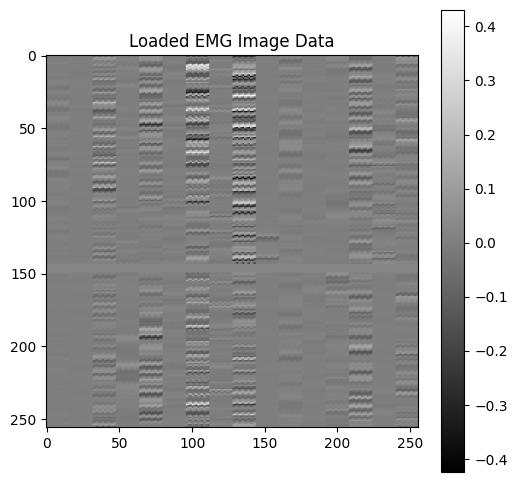

In [21]:
# ファイルパスを指定
# file_path = os.path.join(output_folder, exp_name, "train", "0001", "0.npy")
file_path = os.path.join(output_folder, exp_name, "train", "0001", "0.pkl")

# NumPy配列としてファイルを読み込む
# image_data = np.load(file_path)
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

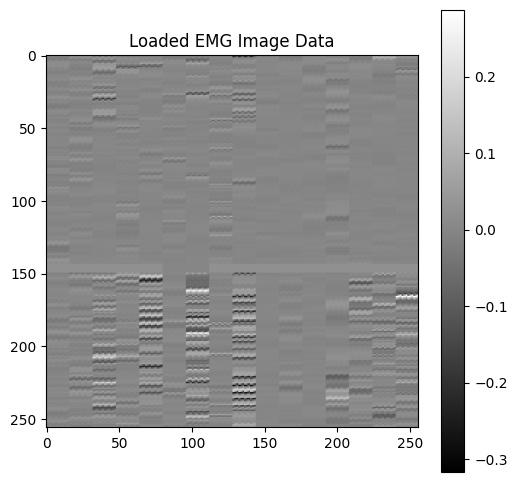

In [22]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "train", "0001", "1.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

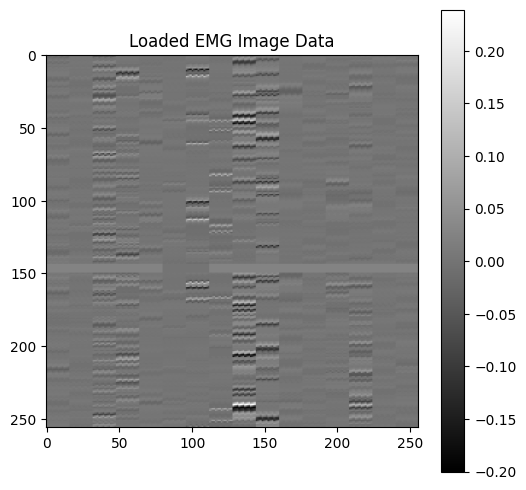

In [23]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "train", "0001", "2.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

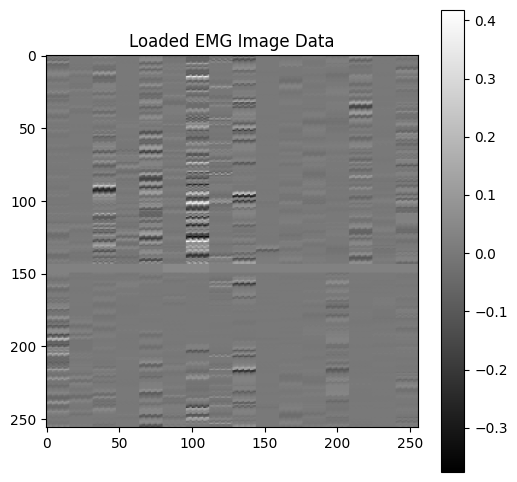

In [24]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "train", "0001", "3.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

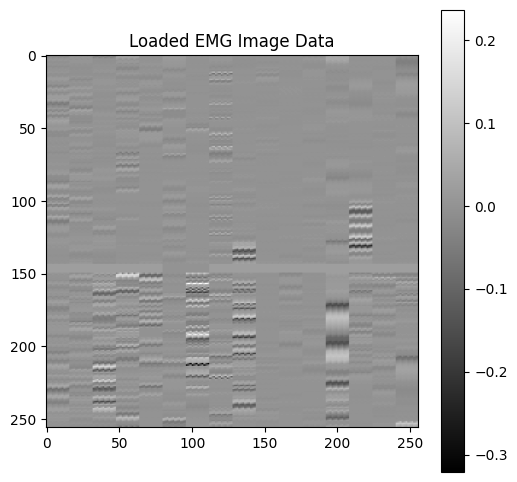

In [25]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "train", "0001", "4.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

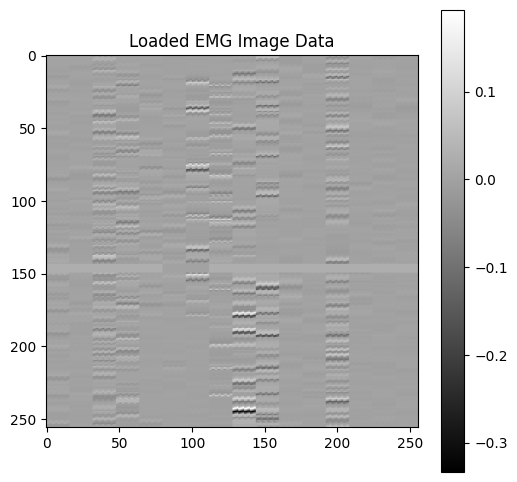

In [26]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "train", "0001", "5.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

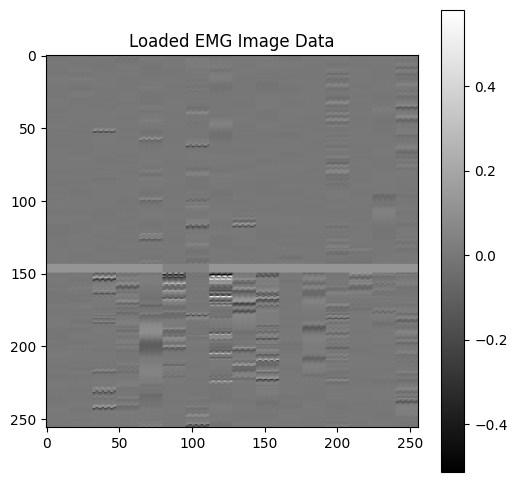

In [27]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "test", "0005", "0.pkl")

# NumPy配列としてファイルを読み込む
# image_data = np.load(file_path)
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

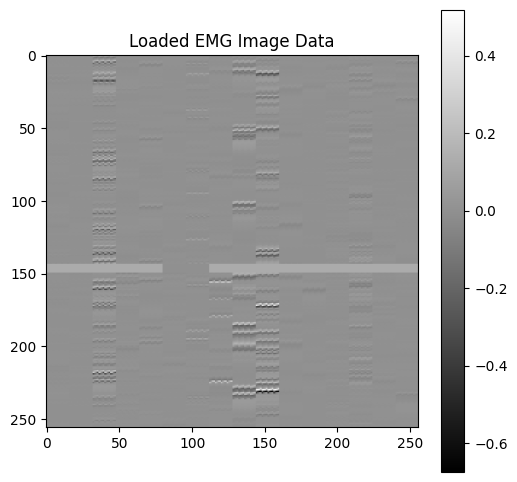

In [28]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "test", "0005", "1.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

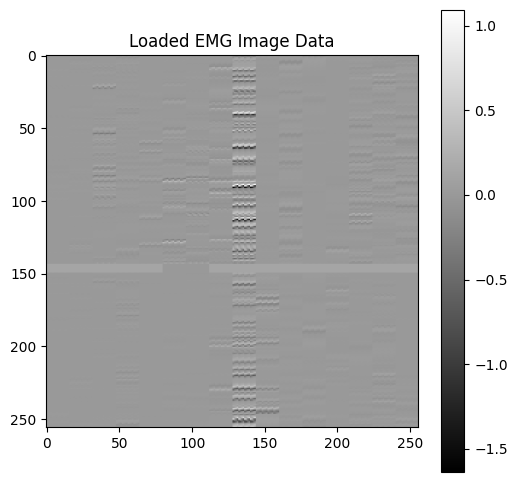

In [29]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "test", "0005", "2.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

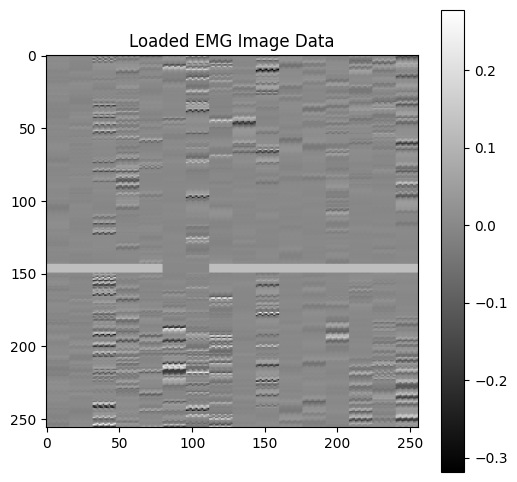

In [30]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "test", "0005", "3.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

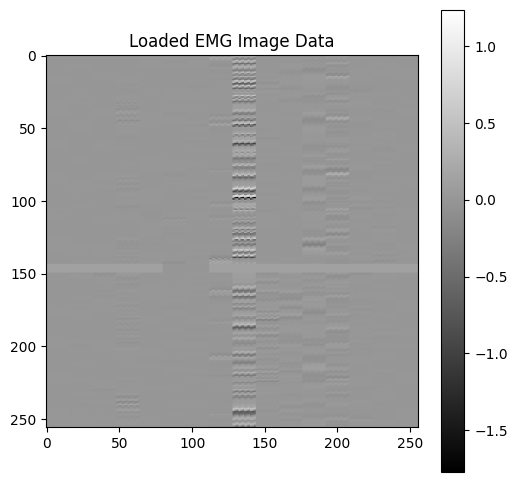

In [31]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "test", "0005", "4.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

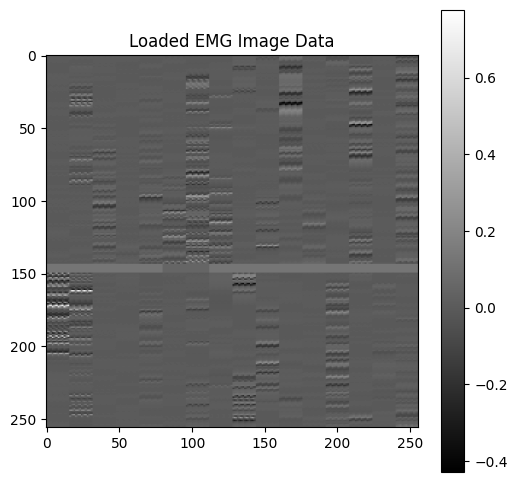

In [32]:
# ファイルパスを指定
file_path = os.path.join(output_folder, exp_name, "test", "0005", "5.pkl")
image_data = load_data_with_pickle(file_path)

# 読み込んだデータを表示
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title("Loaded EMG Image Data")
plt.show()

## データ読込み

In [33]:
# データの読み込みと前処理
def load_data(output_folder, exp_name):
    features, labels, user_trials = [], [], []

    for user_id in ["0001", "0002", "0003", "0004"]:
        y_array = train[user_id][0][0][1]
        y_array = y_array.transpose(0, 2, 1)
        
        for i in range(y_array.shape[0]):
            # label_path = os.path.join(output_folder, exp_name, "train", user_id, f"{i}.npy")
            label_path = os.path.join(output_folder, exp_name, "train", user_id, f"{i}.pkl")
            if os.path.exists(label_path):
                features.append(label_path)
                labels.append(y_array[i].reshape(-1))  # 90次元ベクトルに変換
                user_trials.append(f"{i}") # ユーザーIDと試行回数でグループ化

    for user_id in ["0005"]:
        y_array = reference[user_id][0][0][1]
        y_array = y_array.transpose(0, 2, 1)
        
        for i in range(y_array.shape[0]):
            # label_path = os.path.join(output_folder, exp_name, "train", user_id, f"{i}.npy")
            label_path = os.path.join(output_folder, exp_name, "train", user_id, f"{i}.pkl")
            if os.path.exists(label_path):
                features.append(label_path)
                labels.append(y_array[i].reshape(-1))  # 90次元ベクトルに変換
                user_trials.append(f"{i}") # ユーザーIDと試行回数でグループ化
    
    # ここでfeaturesとlabelsをNumpy配列に変換
    return np.array(features), np.array(labels), np.array(user_trials)

In [34]:
# 特徴量および正解ラベルの作成
features, labels, user_trials = load_data(output_folder, exp_name)
print(user_trials.shape)

(1579,)


## データセット

In [35]:
# データセット定義
class EMGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # image = np.load(self.features[idx])
        image = load_data_with_pickle(self.features[idx])  # 画像をロード
        
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        image = image.repeat(3, 1, 1)  # Replicates the single channel image across 3 channels
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [36]:
# 全データセットの作成
dataset = EMGDataset(features, labels)

## モデル定義

In [37]:
# CUDAが使用可能かどうかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device.')

Using cuda device.


In [38]:
# patience = 500
# n_epochs = 5000
# batch_size = 16

patience = 100
n_epochs = 1000
# batch_size = 16
# batch_size = 64

batch_size = 32

lr=1e-4
weight_decay=1e-6

In [39]:
# 損失関数
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

# import torchvision.models as models
import torchvision.models as tv_models
from torchvision.models import EfficientNet_B1_Weights

# Maxvit
class EMGNet(nn.Module):
    def __init__(self, num_classes=90):
        super(EMGNet, self).__init__()
        self.base_model = timm.create_model('maxvit_rmlp_tiny_rw_256', pretrained=True)
        self.features_dim = 1000

        # 分類器を置き換え
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.features_dim),  # レイヤー正規化を追加
            nn.Linear(self.features_dim, num_classes)  # 線形層
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

# 学習処理の定義
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=10, fold=None):    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Train
        model.train()
        total_loss = 0
        for images, velocities in train_loader:
            images, velocities = images.to(device), velocities.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, velocities)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        # Valid
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, velocities in val_loader:
                images, velocities = images.to(device), velocities.to(device)
                outputs = model(images)
                loss = criterion(outputs, velocities)
                val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_save_path = os.path.join(output_folder, exp_name, f"model_fold_{fold+1}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"Epoch {epoch+1}: Validation loss improved, saving model to {model_save_path}.")
            patience_counter = 0  # reset counter
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1}: No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        if epoch == num_epochs-1:
            model_save_path = os.path.join(output_folder, exp_name, f"model_fold_{fold+1}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"--- Epoch End, saving model to {model_save_path}. ---")
            
    return train_losses, val_losses


## 学習

In [40]:
# データの読み込みと前処理
def assign_data_categories(output_folder, exp_name):
    features, labels, user_trials = [], [], []
    categories = []
    j = 0

    for user_id in ["0001", "0002", "0003", "0004"]:
        y_array = train[user_id][0][0][1]
        y_array = y_array.transpose(0, 2, 1)
        
        for i in range(y_array.shape[0]):
            category = f"uid{user_id}_clu{labels_train[j]}"
            categories.append(category)
            j += 1

    for user_id in ["0005"]:
        y_array = reference[user_id][0][0][1]
        y_array = y_array.transpose(0, 2, 1)
        
        for i in range(y_array.shape[0]):
            category = f"uid{user_id}_clu{labels_train[j]}"
            categories.append(category)
            j += 1
    
    return np.array(categories)

categories = assign_data_categories(output_folder, exp_name)

In [43]:
# === KFoldの設定 ===

# (1)GroupKFoldのインスタンス化
# gkf = GroupKFold(n_splits=fold_num)

# (2)カテゴリラベルを使い、skfでfold作成
from sklearn.model_selection import StratifiedKFold
label_map = {label: idx for idx, label in enumerate(set(categories))}
encoded_labels = [label_map[label] for label in categories] # カテゴリラベルを15種類のインデックスに変換

skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed) # StratifiedKFoldを使用してFoldを生成

In [44]:
# oof予測値を保存するためのDataFrameを初期化
oof_predictions = np.zeros_like(labels)

oof_predictions.shape

(1579, 90)

In [ ]:


# for fold, (train_idx, val_idx) in enumerate(gkf.split(features, labels, groups=user_trials)): #(1)group k fold
for fold, (train_idx, val_idx) in enumerate(skf.split(features, encoded_labels)): #(2)skf
    print(f"Training fold {fold+1}")
    
    x_train, x_val = features[train_idx], features[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    train_dataset = EMGDataset(x_train, y_train)
    val_dataset = EMGDataset(x_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = EMGNet(num_classes=90).to(device)  # モデルをGPUに移動
        
    # optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    # criterion = nn.MSELoss().to(device)  # 損失関数もGPUに移動
    criterion = RMSELoss().to(device)

    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=n_epochs, fold=fold)

    # 学習曲線のプロットと保存
    fig, ax = plt.subplots()
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_title(f'Learning Curves for Fold {fold+1}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.savefig(os.path.join(output_folder, exp_name, f'Learning_Curve_Fold_{fold+1}.png'))  # 画像として保存
    plt.close(fig)  # リソース解放
    
    # LossデータをCSVファイルとして保存
    loss_data = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses
    })
    loss_data.to_csv(os.path.join(output_folder, exp_name, f'Loss_Data_Fold_{fold+1}.csv'), index=False)

    # バリデーションデータの予測をoof予測配列に格納
    model.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(val_loader):
            images = images.to(device)
            outputs = model(images)
            oof_predictions[val_idx[i * batch_size:(i + 1) * batch_size]] = outputs.cpu().numpy()


Training fold 1
Epoch 1: Validation loss improved, saving model to output/8288_MaxVitTinyTimm_3ch-Exp4x256_RVshift150_Hyp4_bs64_MaxPool_pkl-f10-wGC-VelCatg_wCatg8248woID-10fGMMtruelabels-short_j56/model_fold_1.pth.
Epoch 1, Train Loss: 1.1694778561592103, Validation Loss: 0.8160260438919067
Epoch 2: No improvement in validation loss for 1 epochs.
Epoch 2, Train Loss: 0.7055429259936015, Validation Loss: 0.9074566602706909
Epoch 3: Validation loss improved, saving model to output/8288_MaxVitTinyTimm_3ch-Exp4x256_RVshift150_Hyp4_bs64_MaxPool_pkl-f10-wGC-VelCatg_wCatg8248woID-10fGMMtruelabels-short_j56/model_fold_1.pth.
Epoch 3, Train Loss: 0.6108614060613844, Validation Loss: 0.5832360029220581
Epoch 4: No improvement in validation loss for 1 epochs.
Epoch 4, Train Loss: 0.5005516939693027, Validation Loss: 0.6506222248077392
Epoch 5: No improvement in validation loss for 2 epochs.
Epoch 5, Train Loss: 0.4429295433892144, Validation Loss: 0.7012308716773987
Epoch 6: No improvement in val

## 学習結果の評価

In [ ]:
# 各フォールドのモデルをロードし、予測を更新する
# for fold, (train_idx, val_idx) in enumerate(gkf.split(features, labels, groups=user_trials)):
for fold, (train_idx, val_idx) in enumerate(skf.split(features, encoded_labels)): #(2)skf
    print(f"Updating predictions for fold {fold+1}")
    # print(f"train_idx:{train_idx}")
    # print(f"val_idx:{val_idx}")
    
    # モデルのロード
    model = EMGNet(num_classes=90).to(device)
    model_path = os.path.join(output_folder, exp_name, f"model_fold_{fold+1}.pth")
    model.load_state_dict(torch.load(model_path))
    
    # データセットのロード
    x_val = features[val_idx]
    y_val = labels[val_idx]
    val_dataset = EMGDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # バリデーションデータの予測をoof予測配列に格納
    model.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(val_loader):
            images = images.to(device)
            outputs = model(images)
            oof_predictions[val_idx[i * batch_size:(i + 1) * batch_size]] = outputs.cpu().numpy()


In [ ]:
# 各速度成分を抽出
vel_x = labels[:, 0::3]
vel_y = labels[:, 1::3]
vel_z = labels[:, 2::3]
vel_x_oof = oof_predictions[:, 0::3]
vel_y_oof = oof_predictions[:, 1::3]
vel_z_oof = oof_predictions[:, 2::3]

# DataFrameの作成
train_df = pd.DataFrame({
    'vel_x': vel_x.ravel(),
    'vel_y': vel_y.ravel(),
    'vel_z': vel_z.ravel(),
    'vel_x_predicted': vel_x_oof.ravel(),
    'vel_y_predicted': vel_y_oof.ravel(),
    'vel_z_predicted': vel_z_oof.ravel()
})


In [ ]:
# ディレクトリパスを定義
directory_path = os.path.join(output_folder, exp_name, "train")

# 各ユーザーフォルダの内容を取得して、trialとuser_idを設定
user_ids = []
trials = []
timestamps = []
for user_id in sorted(os.listdir(directory_path)):
    user_folder = os.path.join(directory_path, user_id)
    trial_files = sorted(os.listdir(user_folder), key=lambda x: int(x.split('.')[0]))  # ファイルを番号順にソート
    for trial_file in trial_files:
        trial_number = int(trial_file.split('.')[0])
        # トライアルごとに30回のtimestampを追加
        for timestamp in range(30):
            user_ids.append(user_id)
            trials.append(trial_number)
            timestamps.append(timestamp)

# DataFrameに追加
train_df['timestamp'] = timestamps
train_df['trial'] = trials
train_df['user_id'] = user_ids

In [ ]:
train_df

In [ ]:
# 全体の重心速度xyzのスコア
vel_x_score = np.round(np.sqrt(mean_squared_error(train_df["vel_x"], train_df["vel_x_predicted"])), 6)
vel_y_score = np.round(np.sqrt(mean_squared_error(train_df["vel_y"], train_df["vel_y_predicted"])), 6)
vel_z_score = np.round(np.sqrt(mean_squared_error(train_df["vel_z"], train_df["vel_z_predicted"])), 6)
print(f"vel_x_rmse: {vel_x_score}, vel_y_rmse: {vel_y_score}, vel_z_rmse: {vel_z_score}")

In [ ]:
# ユーザーと速度ベクトル方向ごとのスコア
for user_id in train_df["user_id"].unique():
    y_true, y_pred = [], []
    for l in ["vel_x", "vel_y", "vel_z"]:
        y_t = train_df[train_df["user_id"] == user_id][f"{l}"].values
        y_p = train_df[train_df["user_id"] == user_id][f"{l}_predicted"].values
        score = np.round(np.sqrt(mean_squared_error(y_t, y_p)), 6)
        print(f"{user_id} {l}: {score}")

In [ ]:
plotsize = 3

# Calculate correlation coefficients
corr_x = np.corrcoef(train_df["vel_x_predicted"], train_df["vel_x"])[0, 1]
corr_y = np.corrcoef(train_df["vel_y_predicted"], train_df["vel_y"])[0, 1]
corr_z = np.corrcoef(train_df["vel_z_predicted"], train_df["vel_z"])[0, 1]

# Plot
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# Vel_x comparison
ax[0].scatter(train_df["vel_x_predicted"], train_df["vel_x"], alpha=0.5, s=plotsize)
ax[0].plot([train_df["vel_x"].min(), train_df["vel_x"].max()], [train_df["vel_x"].min(), train_df["vel_x"].max()], 'r--')
ax[0].set_title(f'Vel_x: Correlation={corr_x:.2f}')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Vel_y comparison
ax[1].scatter(train_df["vel_y_predicted"], train_df["vel_y"], alpha=0.5, s=plotsize)
ax[1].plot([train_df["vel_y"].min(), train_df["vel_y"].max()], [train_df["vel_y"].min(), train_df["vel_y"].max()], 'r--')
ax[1].set_title(f'Vel_y: Correlation={corr_y:.2f}')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

# Vel_z comparison
ax[2].scatter(train_df["vel_z_predicted"], train_df["vel_z"], alpha=0.5, s=plotsize)
ax[2].plot([train_df["vel_z"].min(), train_df["vel_z"].max()], [train_df["vel_z"].min(), train_df["vel_z"].max()], 'r--')
ax[2].set_title(f'Vel_z: Correlation={corr_z:.2f}')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('True')

# plt.show()
plt.savefig(os.path.join(output_folder, exp_name, f"scatter.png"))  # グラフをファイルに保存
plt.close()  # リソースを解放

print(f'Correlation coefficients:\nVel_x: {corr_x}\nVel_y: {corr_y}\nVel_z: {corr_z}')

In [ ]:
scores = []
for user_id, group1 in train_df.groupby("user_id"):
    if user_id != "0005":  # "0005" をスキップ
        error_list = []
        for trial, group2 in group1.groupby("trial"):
            # numpyに変換して、transposeで(速度ベクトル, time)に変換すると元データに戻せる
            y_t = group2[["vel_x", "vel_y", "vel_z"]].to_numpy()
            # 予測用
            y_p = group2[["vel_x_predicted", "vel_y_predicted", "vel_z_predicted"]].to_numpy()
            
            trial_rmse = np.sqrt(((y_t-y_p)**2).sum(axis=1).mean())
            
            error_list.append(trial_rmse)
        print(f"{user_id} rmse_3d mean: {np.mean(error_list)}")
        scores.append(np.mean(error_list))
print(f"RMSE_3D Mean: {np.mean(scores)}")
CVscore = np.mean(scores)

In [ ]:
# 出力フォルダのパスを設定
output_path = os.path.join(output_folder, exp_name)

# user_id別にデータをフィルタリングし、CSVファイルに保存
for user_id in train_df['user_id'].unique():
    # ファイル名を生成
    file_name = f'train_{user_id}.csv'
    # user_idに合致するデータを抽出
    user_data = train_df[train_df['user_id'] == user_id][['vel_x_predicted', 'vel_y_predicted', 'vel_z_predicted', 'vel_x', 'vel_y', 'vel_z']]
    # CSVに保存
    user_data.to_csv(os.path.join(output_path, file_name), index=False)

## 推論

In [ ]:
# テストデータのファイルパスを取得
def get_test_files(base_path):
    file_paths = []
    for user_id in ["0001", "0002", "0003", "0004", "0005"]:
        user_folder = os.path.join(base_path, user_id)
        files = sorted(os.listdir(user_folder), key=lambda x: int(x.split('.')[0]))
        for file in files:
            file_paths.append(os.path.join(user_folder, file))
    return file_paths

# 推論関数
def predict(test_files, models):
    predictions = []
    for file_path in test_files:
        # image_data = np.load(file_path)
        # image_tensor = torch.tensor(image_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        # image_data = np.load(file_path)
        image_data = load_data_with_pickle(file_path)  # 画像をロード

        
        image_tensor = torch.tensor(image_data, dtype=torch.float32).unsqueeze(0)
        image_tensor = image_tensor.repeat(3, 1, 1).unsqueeze(0)  # Replicates the single channel image across 3 channels
        image_tensor = image_tensor.to(device)
        
        # 各foldのモデルで予測し平均を取る
        fold_predictions = []
        for model in models:
            model.eval()
            with torch.no_grad():
                prediction = model(image_tensor)
                fold_predictions.append(prediction.cpu().numpy())
        
        predictions.append(np.mean(fold_predictions, axis=0))
    
    return np.vstack(predictions)

# モデルの読み込み
models = []
for fold in range(1, fold_num+1):
    model = EMGNet(num_classes=90).to(device)

    # 重みファイルの保存先を指定
    model_save_path = os.path.join(output_folder, exp_name, f"model_fold_{fold}.pth")
    model.load_state_dict(torch.load(model_save_path))
    models.append(model)



In [ ]:
# テストデータの推論
test_files = get_test_files(os.path.join(output_folder, exp_name, "test"))
predictions = predict(test_files, models)

In [ ]:
predictions.shape

In [ ]:
# 各速度成分を抽出
vel_x = predictions[:, 0::3]
vel_y = predictions[:, 1::3]
vel_z = predictions[:, 2::3]

# DataFrameの作成
test_df = pd.DataFrame({
    'vel_x_predicted': vel_x.ravel(),
    'vel_y_predicted': vel_y.ravel(),
    'vel_z_predicted': vel_z.ravel()
})

In [ ]:
# ディレクトリパスを定義
directory_path = os.path.join(output_folder, exp_name, "test")

# 各ユーザーフォルダの内容を取得して、trialとuser_idを設定
user_ids = []
trials = []
timestamps = []
vel_xs = []
vel_ys = []
vel_zs = []

for user_id in ["0001", "0002", "0003", "0004"]:
    user_folder = os.path.join(directory_path, user_id)
    trial_files = sorted(os.listdir(user_folder), key=lambda x: int(x.split('.')[0]))  # ファイルを番号順にソート
    for trial_file in trial_files:
        trial_number = int(trial_file.split('.')[0])
        # トライアルごとに30回のtimestampを追加
        for timestamp in range(30):
            user_ids.append(user_id)
            trials.append(trial_number)
            timestamps.append(timestamp)
            vel_xs.append(0)
            vel_ys.append(0)
            vel_zs.append(0)

for user_id in ["0005"]:
    user_folder = os.path.join(directory_path, user_id)
    trial_files = sorted(os.listdir(user_folder), key=lambda x: int(x.split('.')[0]))  # ファイルを番号順にソート
    for trial_file in trial_files:
        trial_number = int(trial_file.split('.')[0])
        # トライアルごとに30回のtimestampを追加
        for timestamp in range(30):
            user_ids.append(user_id)
            trials.append(trial_number)
            timestamps.append(timestamp)

    # 正解ラベル
    y_array = reference[user_id][0][0][3] # 評価用データの重心速度データ
    y_array = y_array.transpose(0, 2, 1)
    for i, y_arr in enumerate(y_array):
        vel_xs = vel_xs + y_arr[:, 0].tolist()
        vel_ys = vel_ys + y_arr[:, 1].tolist()
        vel_zs = vel_zs + y_arr[:, 2].tolist()

# DataFrameに追加
test_df['timestamp'] = timestamps
test_df['trial'] = trials
test_df['user_id'] = user_ids
test_df['vel_x'] = vel_xs
test_df['vel_y'] = vel_ys
test_df['vel_z'] = vel_zs

# XY速度の反転

In [ ]:
test_df

In [ ]:
test_df["vel_x_predicted"] *= -1
test_df["vel_y_predicted"] *= -1

In [ ]:
test_df[["vel_x_predicted", "vel_y_predicted", "vel_z_predicted"]]

In [ ]:
scores = []
for user_id, group1 in test_df.groupby("user_id"):
    if user_id == "0005":  # "0005" だけ評価
        error_list = []
        for trial, group2 in group1.groupby("trial"):
            # numpyに変換して、transposeで(速度ベクトル, time)に変換すると元データに戻せる
            y_t = group2[["vel_x", "vel_y", "vel_z"]].to_numpy()
            # 予測用
            y_p = group2[["vel_x_predicted", "vel_y_predicted", "vel_z_predicted"]].to_numpy()
            
            trial_rmse = np.sqrt(((y_t-y_p)**2).sum(axis=1).mean())
            
            error_list.append(trial_rmse)
        print(f"{user_id} rmse_3d mean: {np.mean(error_list)}")
        scores.append(np.mean(error_list))
print(f"RMSE_3D Mean: {np.mean(scores)}")
Test0005_score = np.mean(scores)

In [ ]:
# 出力フォルダのパスを設定
output_path = os.path.join(output_folder, exp_name)

# user_id別にデータをフィルタリングし、CSVファイルに保存
for user_id in test_df['user_id'].unique():
    # ファイル名を生成
    file_name = f'test_{user_id}.csv'
    # user_idに合致するデータを抽出
    user_data = test_df[test_df['user_id'] == user_id][['vel_x_predicted', 'vel_y_predicted', 'vel_z_predicted', 'vel_x', 'vel_y', 'vel_z']]
    # CSVに保存
    user_data.to_csv(os.path.join(output_path, file_name), index=False)

## 予測結果の提出
各fold毎の学習済みモデルを用いて、テストデータの予測結果を行いました。これを提出ファイルに修正していきましょう。

予測ファイルはsample_submit.jsonのフォーマットに従って修正します。

読み込んで確認してみましょう。

In [ ]:
# サンプル提出ファイルを確認します
with open("dataset/sample_submit.json") as r:
    sample_submit = json.load(r)

In [ ]:
# キーの確認
print(sample_submit.keys())

jsonファイルの中身は以下の様になっていることがわかりました。

{"sub1": {"trial1": list, "trial2", list, ...}, "sub2": {"trial1": list, "trial2", list, ...}, "sub3": {"trial1": list, "trial2", list, ...}, "sub4": {"trial1": list, "trial2", list, ...}}
またlistは、長さ3のリストが30個格納されているlistであることがわかりました。

これはnumpy配列に直すと(30, 3)となり、一つのリストにx,y,zの重心速度のデータが格納されています。

ここから、ユーザーid毎にtrial: (タイムポイント, 重心速度xyz)となるように修正していきます。

テストデータの各ユーザーのtrial数は、

sub1:    319
sub2:    300
sub3:    320
sub4:    320
です。

そこにsub1の中のdictでは、{"trial1": list, "trial2": list, ...}となっていました。

listはarray型では、(30,3)の配列となっています。

作成していきましょう。

In [ ]:
for i, (user_id, group1) in enumerate(test_df.groupby("user_id")):
    if user_id != "0005":  # "0005" をスキップ
        print(f'i:{i}, user_id:{user_id}')
        sub_dict = {}
        for trial, group2 in group1.groupby("trial"):
            # 配列を(30, 3)にします
            y_pred = group2[["vel_x_predicted", "vel_y_predicted", "vel_z_predicted"]].to_numpy()
            # print(y_pred.shape)
            sub_dict[f"trial{trial+1}"] = y_pred.tolist() # ------------------ 注意点 ---------------
            # sub_dict[f"trial{trial+1}"] = y_pred.tolist() # ------------------ 注意点 ---------------
        # 予測に追加(0001はsub1、0002はsub2、0003はsub3、0004はsub4に対応しています)
        sample_submit[f"sub{i+1}"] = sub_dict

In [ ]:
# 各軸のデータを抽出
trial_num = 'trial1'
# trial_num = 'trial101'
vel_x = [item[0] for item in sample_submit["sub1"][trial_num]]
vel_y = [item[1] for item in sample_submit["sub1"][trial_num]]
vel_z = [item[2] for item in sample_submit["sub1"][trial_num]]

# プロット
plt.figure(figsize=(10, 5))
plt.plot(vel_x, label="vel_x")
plt.plot(vel_y, label="vel_y")
plt.plot(vel_z, label="vel_z")
plt.legend()
plt.title("Velocity Time Series")
plt.xlabel("Time Point")
plt.ylabel("Velocity")
plt.show()

# 各軸のデータを抽出
trial_num = 'trial2'
# trial_num = 'trial101'
vel_x = [item[0] for item in sample_submit["sub1"][trial_num]]
vel_y = [item[1] for item in sample_submit["sub1"][trial_num]]
vel_z = [item[2] for item in sample_submit["sub1"][trial_num]]

# プロット
plt.figure(figsize=(10, 5))
plt.plot(vel_x, label="vel_x")
plt.plot(vel_y, label="vel_y")
plt.plot(vel_z, label="vel_z")
plt.legend()
plt.title("Velocity Time Series")
plt.xlabel("Time Point")
plt.ylabel("Velocity")
plt.show()

# 各軸のデータを抽出
trial_num = 'trial3'
# trial_num = 'trial101'
vel_x = [item[0] for item in sample_submit["sub1"][trial_num]]
vel_y = [item[1] for item in sample_submit["sub1"][trial_num]]
vel_z = [item[2] for item in sample_submit["sub1"][trial_num]]

# プロット
plt.figure(figsize=(10, 5))
plt.plot(vel_x, label="vel_x")
plt.plot(vel_y, label="vel_y")
plt.plot(vel_z, label="vel_z")
plt.legend()
plt.title("Velocity Time Series")
plt.xlabel("Time Point")
plt.ylabel("Velocity")
plt.show()

In [ ]:
# 長さの確認をします
print(sample_submit.keys())
for k in sample_submit.keys():
    print(k, len(sample_submit[k]))

In [ ]:
print(sample_submit)

In [ ]:
# 予測結果の中身に問題がないことを確認します
for k in sample_submit.keys():
    for kk in sample_submit[k].keys():
        # (30, 3)の形でなければ例外を出す
        if np.array(sample_submit[k][kk]).shape != (30, 3):
            print(f"invalid: {k} {kk}")

In [ ]:
# フォーマットされたCVスコアをファイル名に使用
formatted_cv_score = f"{CVscore:.4f}"
submission_filename = f"submission_{formatted_cv_score}.json"
submission_path = os.path.join(output_folder, exp_name, submission_filename)

# 提出ファイルとして保存
with open(submission_path, "w") as f:
    json.dump(sample_submit, f)

print(f"Submission file saved as {submission_path}")